In [1]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

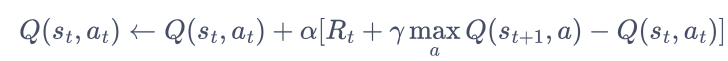  
$$TD\_target=r_{t}+\gamma \underset {a}{max} q_t(s_{t+1},a_{t+1})$$
$$TD\_error=TD\_target- q_t(s_{t},a_{t})$$
$$q_{t+1}(s_{t},a_{t})=q_{t}(s_{t},a_{t})+\alpha* TD\_error$$
$(s_{t},a_{t})$是输入条件，$(r_{t},s_{t+1})$是与环境进行交互得到的  
有$(s_{t},a_{t},r_{t},s_{t+1})$就可以得到$TD\_target$更新Q(目标策略)，  
下一次通过一定的policy(行为策略)从$s_{t+1}$状态选择$a_{t+1}$  
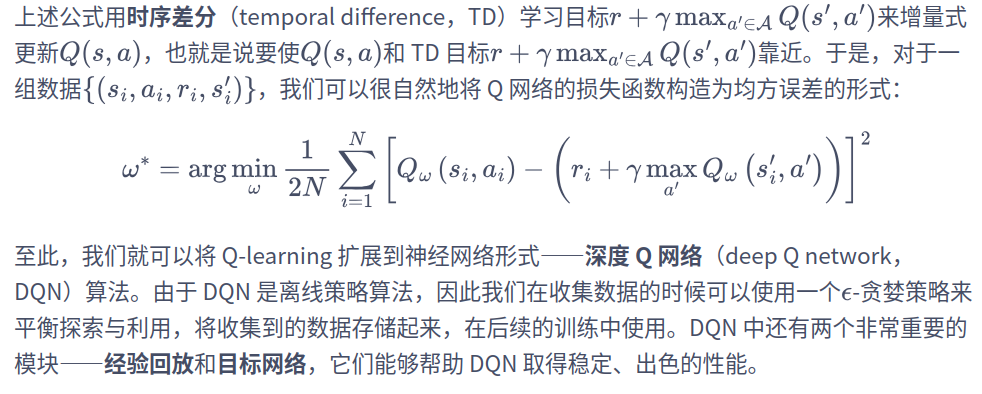

经验回放

在一般的有监督学习中，假设训练数据是独立同分布的，我们每次训练神经网络的时候从训练数据中随机采样一个或若干个数据来进行梯度下降，  
随着学习的不断进行，每一个训练数据会被使用多次。在原来的 Q-learning 算法中，每一个数据只会用来更新一次Q值。  
为了更好地将 Q-learning 和深度神经网络结合，DQN 算法采用了经验回放（experience replay）方法，具体做法为维护一个回放缓冲区，  
将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练。  
这么做可以起到以下两个作用。  

（1）使样本满足独立假设。在 MDP 中交互采样得到的数据本身不满足独立假设，因为这一时刻的状态和上一时刻的状态有关。  
非独立同分布的数据对训练神经网络有很大的影响，会使神经网络拟合到最近训练的数据上。  
采用经验回放可以打破样本之间的相关性，让其满足独立假设。

（2）提高样本效率。每一个样本可以被使用多次，十分适合深度神经网络的梯度学习。  

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

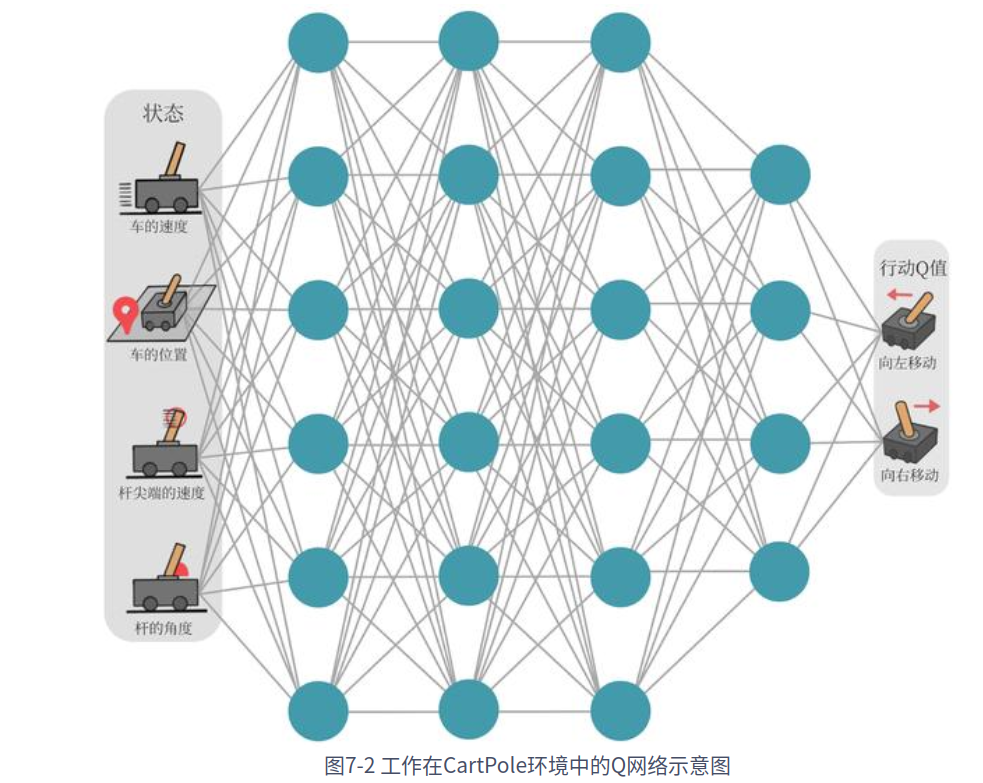


In [ ]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)
        # (batch_size,action_dim)

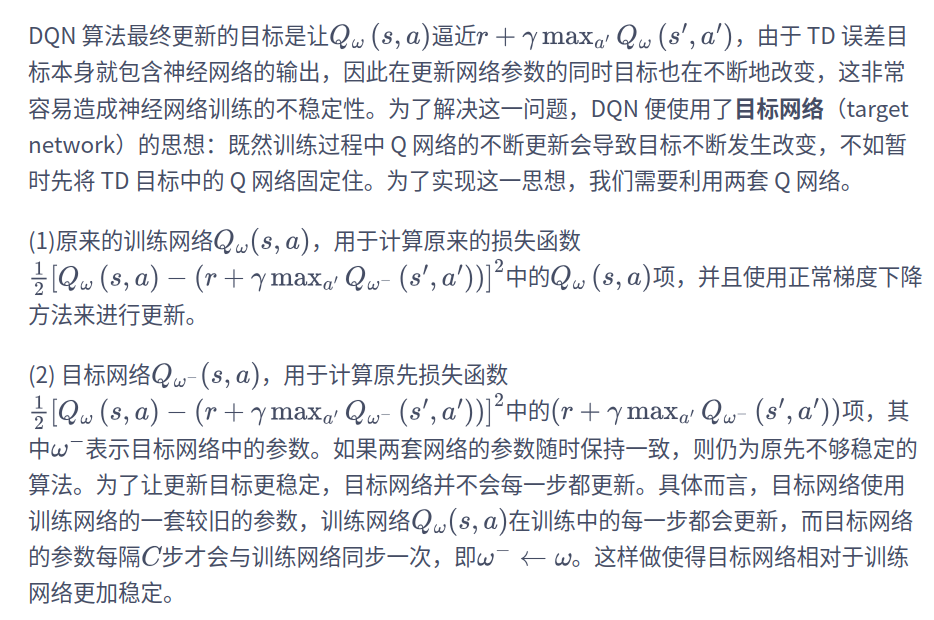

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim

        self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)

        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        # transition_dict['states']得到的是多个样本采样获取的状态的一维list,[s0,s1,s2,...,sn]
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)

        # view方法使一维变成二维,形状均为(batch_size,1)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        
        # self.q_net(states)输入状态(batch_size,state_dim),输出每个动作的Q_value(batch_size,action_dim)
        # (batch_size,action_dim)->gather,index=action->(batch_size,1),dim=1
        # action是动作的索引,out[i][0]=Q_value[i][action[i][0]]
        # 相当于选择了动作索引对应的Q_value
        q_values = self.q_net(states).gather(1, actions) 
        # 下个状态的最大Q值
        # 输入状态(batch_size,state_dim),输出每个动作的Q_value(batch_size,action_dim)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        # .max(1)降维成一维Q(batch_size,),返回(Q,index)分别是值和索引
        # 最终形状为(batch_size,1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD_target
        # 其实就是TD_error的MSE作为loss
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()
        # 只进行了一次参数更新
        
        # 更新目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  
        self.count += 1

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
# env = env.unwrapped  # 解封装才能访问状态转移矩阵P
# env.reset()  # 关键修正：初始化环境状态
# env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境

random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            # env.reset()返回的是一个元组 (state_array, info_dict)
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _, _= env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                    # 进行一次参数更新
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_75264/3235635346.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s, episode=500, return=232.400] 


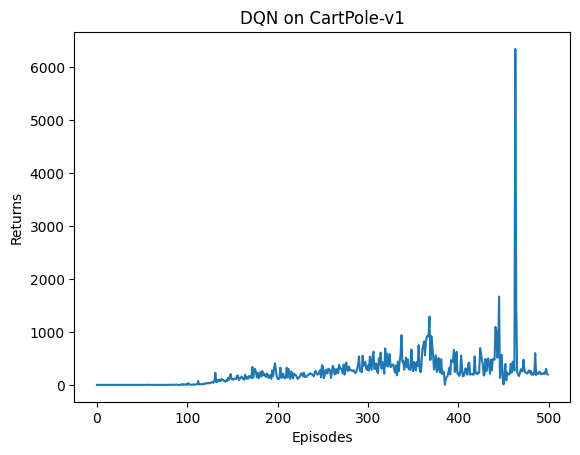

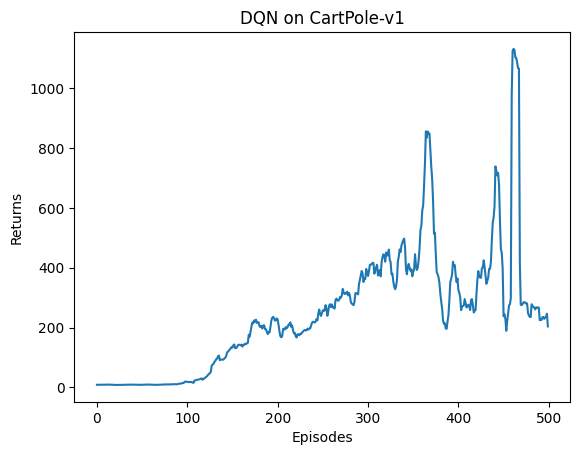

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [7]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)